# Get top altered structural connectivity 

In [ ]:
# perform SC t-test by NBS, all the t-value stored in NBS.mat

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from base_station.feature_toolkit import NBS
import numpy as np

NBS_path1 = r'E:\017_narcolepsy_analysis\NBS.mat'
t_matrix = NBS.readin_NBS_test_stats(NBS_path1)

arr = t_matrix
flattened = arr.flatten()
# Get the indices of the top 5 highest values using np.argpartition
top_indices = np.argpartition(flattened, -10)[-10:]
# Convert the flattened indices to 2D indices using np.unravel_index
row_indices, col_indices = np.unravel_index(top_indices, arr.shape)
# Print the top 5 highest values and their indices
for i in range(len(row_indices)):
    print(f"Value: {arr[row_indices[i], col_indices[i]]}, Index: ({row_indices[i]}, {col_indices[i]})")


# Graph theory analysis by brant & group/subgroup comparison

In [ ]:
# network metric comparison

import os
import sys
import nibabel as nib
import shutil
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import seaborn as sns
import matplotlib.pyplot as plt
from base_station.datamanagement import subject as ss
import numpy as np
import pandas as pd



subjects = ss.load_subjects(r"E:\017_narcolepsy_analysis\01_datamanagement\DTI.csv", csv_encoding="GBK")

threshold_value = 0.1 
out_path = r'E:\017_narcolepsy_analysis'

metrics = ['degree', 'global_efficiency', 'clustering_coefficient']

def make_sorter(l):
    """
    Create a dict from the list to map to 0..len(l)
    Returns a mapper to map a series to this custom sort order
    """
    sort_order = {k:v for k,v in zip(l, range(len(l)))}
    return lambda s: s.map(lambda x: sort_order[x])

sorter = ['HC', 'narcolepsy', 'cataplexy+',  'cataplexy-', "paralysis+", "paralysis-" , "hallucination+", "hallucination-" , "RBD+", "RBD-" ]

for metric in metrics:
    subjects_values = []
    columns = []
    index = []
    i = 0
    for subject in subjects:
        observations = subject.get_all_observation()
        values = []
        for obs_name, obs in observations.items(): 
            value = obs["03_DTI_post"].get_global_metric(metric, mat_name='brant_whole_brain.mat', 
                                               threshold_type='sparsity', 
                                               threshold_value=threshold_value)
            columns.append(obs.name)
            if not np.isinf(value):
                subjects_values.append(float(value))
                index.append(i)
                i += 1
            else:
                print(subject.name)
     
    subjects_values = np.array(subjects_values)
    columns = np.array(columns)
    new_array = np.stack((subjects_values, columns), axis=-1)

    df = pd.DataFrame(data=new_array, index=index, columns=['Value', 'Observation'])
    df[['Value']] = df[['Value']].astype(float)
    df = df.sort_values(by=['Observation'], key=make_sorter(sorter))

    ax = sns.barplot(x='Observation', y="Value", data=df) 
    
    ax.set_title('whole_network_{}'.format(metric))
    
    out_png_path = os.path.join(out_path, 'xxx_sub_{}.png'.format(metric)) 
    out_csv_path = os.path.join(out_path, 'xxx_sub_{}.csv'.format(metric)) 

    plt.show()
    plt.close()
   

In [ ]:
df.to_csv(r"E:\017_narcolepsy_analysis\result.csv")

In [ ]:
# regional metric comparison 
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)



from base_station.datamanagement import subject as ss
import numpy as np
import pandas as pd

from scipy.stats import ttest_rel
from scipy.stats import ttest_ind

threshold_value = 0.1


subjects = ss.load_subjects(r"E:\017_narcolepsy_analysis\01_datamanagement\DTI.csv", csv_encoding="GBK")

metrics = ['degree', 'global_efficiency', 'clustering_coefficient']


obs_name1 = 'HC'
obs_name2 = 'narcolepsy'

for metric in metrics:
    values1 = []
    values2 = []
 
    i = 0
    for subject in subjects:
        obs1 = subject.get_observation(obs_name1)
        obs2 = subject.get_observation(obs_name2)
        value1 = obs1["03_DTI_post"].get_nodal_metric(metric, mat_name='brant_whole_brain.mat', 
                                               threshold_type='sparsity', 
                                               threshold_value=threshold_value)
        value2 = obs2["03_DTI_post"].get_nodal_metric(metric, mat_name='brant_whole_brain.mat', 
                                               threshold_type='sparsity', 
                                               threshold_value=threshold_value)
        
        value1 = np.array(value1) 
        value2 = np.array(value2)

        values1.append(value1.astype(np.float32))
        values2.append(value2.astype(np.float32))

    t, p = ttest_ind(values1, values2)

    print(metric)
    print(t)
    print(p)


In [ ]:
# regional metric comparison

import matplotlib.pyplot as plt
import seaborn as sns

indices = np.argsort(t)[::-1]

x = np.arange(1,247)

t_sorted = t[indices]

rois = np.arange(1,247)
rois_sorted = rois[indices]

fig, ax = plt.subplots(figsize=(20, 6))

top_n = 15

sns.barplot(x=x[:top_n], y=t_sorted[:top_n], ax=ax)
ax.set_xticks(x[:top_n])
ax.set_xticklabels(rois_sorted[:top_n])

plt.show()

# t-value distribution of all SC

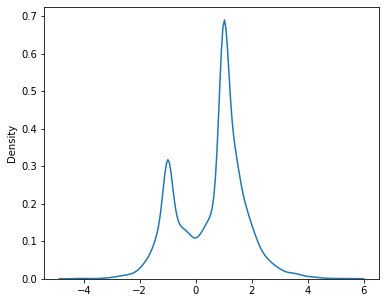

In [4]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import seaborn as sns
from base_station.feature_toolkit import NBS
import matplotlib.pyplot as plt

nbs_path = r'E:\017_narcolepsy_analysis\NBS.mat' 
ttest_values = NBS.readin_NBS_test_stats(nbs_path)
# ttest_values = -ttest_values 
ttest_values = ttest_values.flatten()
ttest_values = ttest_values.astype(np.float32)


xxx = ttest_values[ttest_values != 0]
fig = plt.figure(figsize=(6, 5))
ax = sns.kdeplot(x=xxx, clip=(-6,6))
plt.show()

# Pearson analysis for clinical measures

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

path = r"E:\017_narcolepsy_analysis\01_datamanagement\DTI.csv"

df = pd.read_csv(path, index_col = 0)

value1 = df['network degree'].values

col_names = ["GENDER", "AGE", "INDEX", "ESS","A1","A2","A3","A4","A5","A6","A7","A8","A9","A10"]

for col_name in col_names:
    value2 = df[col_name].values
    r, p = pearsonr(value1, value2)
    print(col_name, r ,p)


In [ ]:
# 将临床资料整理到其中之后，进行pearon
import os
import sys
import nibabel as nib
import statsmodels.api as sm
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from base_station.datamanagement import subject
from base_station.statistics_method import correlation

path = r"E:\017_narcolepsy_analysis\01_datamanagement\DTI.csv"

df = pd.read_csv(path, index_col = 0)

value1 = df['network degree'].values

col_names = ["A26"] 

for col_name in col_names:
    value2 = df[col_name].values
    r, p = pearsonr(value1, value2)
    print(col_name, r , p)
    correlation.correlation(value1, value2, show = False, color="#3274a1") 


# Imaging genetic analysis

In [ ]:
import os
import sys
import nibabel as nib
import shutil
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import seaborn as sns
import matplotlib.pyplot as plt
from base_station.datamanagement import subject as ss
import numpy as np
import pandas as pd


from scipy.stats import ttest_rel
from scipy.stats import ttest_ind

threshold_value = 0.1


subjects = ss.load_subjects(r"E:\017_narcolepsy_analysis\01_datamanagement\DTI.csv", csv_encoding="GBK")

metrics = ['degree', 'global_efficiency', 'clustering_coefficient']

obs_name1 = 'HC'
obs_name2 = 'narcolepsy'

for metric in metrics:
    values1 = []
    values2 = []
 
    i = 0
    for subject in subjects:
        obs1 = subject.get_observation(obs_name1)
        obs2 = subject.get_observation(obs_name2)
        value1 = obs1["03_DTI_post"].get_nodal_metric(metric, mat_name='brant_whole_brain.mat', #对应的NBS文件，这里本质上就是一个路径阅读
                                               threshold_type='sparsity', #阈值类型
                                               threshold_value=threshold_value)
        value2 = obs2["03_DTI_post"].get_nodal_metric(metric, mat_name='brant_whole_brain.mat', #对应的NBS文件，这里本质上就是一个路径阅读
                                               threshold_type='sparsity', #阈值类型
                                               threshold_value=threshold_value)
        values1.append(value1)
        values2.append(value2)


    values1 = np.array(values1)
    values2 = np.array(values2)

    values1 = values1.astype(np.float32)
    values2 = values2.astype(np.float32)

    t, p = ttest_ind(values2, values1)

    print(metric)
    print(t)
    print(p)


In [ ]:
import os
import sys
import nibabel as nib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import seaborn as sns
import matplotlib.pyplot as plt
from base_station.statistics_method.plsr import plsr

ts_dict = dict(zip(np.arange(1,247), t))

model = plsr(ts_dict, gene_path=r'E:\01_AHBAexpression\expression.csv', n_perm=5000, n_boot=1,
             out_csv_path=r'E:\017_narcolepsy_analysis\result.csv', out_model_path=r'E:\017_narcolepsy_analysis\result_GE.pkl')

model.permres.pvals

model.varexp

# nilearn plotting

In [ ]:
from nilearn import plotting
import numpy as np
edges = [(184, 185), (184, 230), (184, 236), (185, 221), (185, 227), (219, 227)]
test_stats = np.zeros(shape=(246,246))
for edge in edges:
    i, j = edge
    test_stats[i][j] = 1
    test_stats[j][i] = 1

node_coords = np.loadtxt(r'E:\BN_nbs_bold\BN_MNI.txt')
plotting.plot_connectome(test_stats, node_coords, node_size=5)
plt.show()

#  PET/SPECT maps of glutamatergic neuropathophysiological feature

In [ ]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import os
import sys
import nibabel as nib
import shutil
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import seaborn as sns
import matplotlib.pyplot as plt
from base_station.statistics_method import correlation as correlation


juspace_dir = r'E:\017_narcolepsy_analysis\Glu'

files = os.listdir(juspace_dir)
for f in files:
    path = os.path.join(juspace_dir, f)
    jdf = pd.read_csv(path, index_col=0)
    juspace_values = jdf['Value'].values

    r, p = correlation.hexplot(degree_t, juspace_values, show=False)
    if p<0.05:
        print(f, r, p)
        r, p = correlation.hexplot(degree_t, juspace_values, show=False, save=True,out_path=r"E:\017_narcolepsy_analysis\{}-{}-{}.png".format(f, r, p))

In [ ]:
from nilearn.plotting import find_parcellation_cut_coords
from scipy.spatial.distance import pdist, squareform
from brainsmash.mapgen.base import Base

nii = nib.load(r"E:\03_Brainnetome\BN_Atlas_246_1mm_182space.nii.gz")
n = 5000

roi_coords = find_parcellation_cut_coords(nii)
# Calculate the pairwise distances between all ROIs
distances = pdist(roi_coords)
distance_matrix = squareform(distances)

gen = Base(degree_t, distance_matrix)  # note: can pass numpy arrays as well as filenames
surrogate_maps = gen(n=n)

In [ ]:
juspace_dir = r'E:\017_narcolepsy_analysis\Glu'

files = os.listdir(juspace_dir)
for f in files:
    path = os.path.join(juspace_dir, f)
    jdf = pd.read_csv(path, index_col=0)
    juspace_values = jdf['Value'].values

    # main result
    r1, p1 = correlation.hexplot(degree_t, juspace_values, show=False)
    
    surrogate_rs = []
    # for surrogate maps
    for sur_map in surrogate_maps:
        r2, p2 = correlation.hexplot(sur_map, juspace_values, show=False)

        surrogate_rs.append(r2)
    surrogate_rs = np.array(surrogate_rs)

    if r1 > 0:
        print(f, 1 - np.sum(r1>surrogate_rs)/np.shape(surrogate_rs)[0])
    if r1 < 0:
        print(f, 1 - np.sum(r1<surrogate_rs)/np.shape(surrogate_rs)[0])
